In [74]:
#library import - tensorflow/keras/sklearn/matplotlib
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [75]:
#dataset 구성
datapath = join('data', 'wafer')
url = "E:/WaferMap"
#print(os.listdir(url))  #dir list

#경고 메시지 끄기(ignore), 켜기(default)
import warnings
warnings.filterwarnings("ignore")

In [76]:
#read pickle 파일
#https://www.kaggle.com/code/kcs93023/keras-wafer-classification-cnn2d-with-augmentation/data
df=pd.read_pickle(url+"/LSWMD.pkl")

> pickle 파일구성 (이미 학습할 수 있도록, 분류가 된 파일)
 - waferMap file 개수: 811,457 rows(2차원 행렬 data, 행*열=waferMapDim에 있음)
 - 6개 컬럼(wafer map, die size, lot name, index, T/T type, failType) 
  --> failuretype: 불량 유형 (none, edge-ring...)


> 데이터 구성

```
# none_label: 638,507 - 78.7%
# label: 172,950 - 21.3%   
   - ng: 25,519 	14.8%(3.1%) --> 불량 항목 별로도 데이터 불균형
   - ok: 147,431 	85.2%(18.2%)
```

In [334]:
#data file 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   failureNum      811457 non-null  object 
 6   trainTestNum    811457 non-null  object 
 7   waferMapDim     811457 non-null  object 
dtypes: float64(1), object(7)
memory usage: 49.5+ MB


In [335]:
#해더 내용
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"


In [79]:
#tail 내용
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [ ]:
#csv 파일로도 한번 받아 봄(583mb)
#df.to_csv(path_or_buf = 'wafermap.csv', \
           #sep=str(','), header=True, index=True, mode='w', encoding='CP949')

In [333]:
# 1lot = 25장 wafer인데(1lot / wafer index = 1~25)
# lot의 wafer index 별로 보면, 없는 데이터도 존재 함
import matplotlib.pyplot as plt

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'waferIndex'

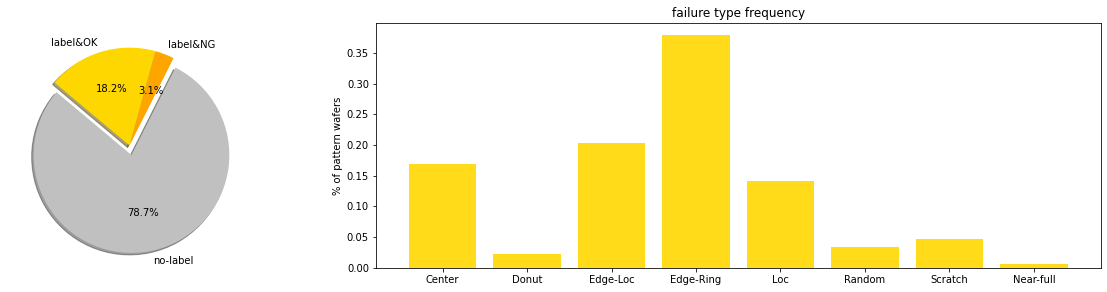

In [328]:
#데이터 분포 라벨링율 = 21.3%
#데이터 분포 ok : ng = 85.2:14.8
#데이터 분포 ng(detection) 내 의 code별 분포
df['failureNum']=df.failureType #컬럼 추가
df['trainTestNum']=df.trianTestLabel    #컬럼 추가
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}    #불량코드 라벨링
mapping_traintest={'Training':0,'Test':1}   #train:0, test:1 로 라벨링
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})    #replace

#failureType의 label이 존재
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()
#failureType의 label이 존재 && 불량z코드 존재 (0~7번 코드)
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
#failureType의 label이 존재 && OK품(8번 코드, none)
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

#graph - pie
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

tol_wafers = df.shape[0]
no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # pie에서 sclicing해서 차트에서 벗어나게
labels = ['no-label','label&NG','label&OK']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

#graph - bar
uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()
#

In [242]:
labels2

['Center',
 'Donut',
 'Edge-Loc',
 'Edge-Ring',
 'Loc',
 'Random',
 'Scratch',
 'Near-full']

In [330]:
#df head()
df[(df['failureNum']==8)].head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"


In [331]:
# 구분별 개수 찍어 봄
print("total: ", tol_wafers)
print("none-label: ", tol_wafers -df_withlabel.shape[0])
print("label: ", df_withlabel.shape[0])
print("ng: ", df_withpattern.shape[0])
print("ok: ", df_nonpattern.shape[0])

total:  811457
none-label:  638507
label:  172950
ng:  25519
ok:  147431


In [332]:
#wafer index 제외
df = df.drop(['waferIndex'], axis = 1)

KeyError: "['waferIndex'] not found in axis"

In [336]:
#각 wafer map의 해상도 size가 다름 -- 해상도 size에 대한(행렬size) 컬럼과 데이터 생성
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
540174,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",686.0,lot33726,[],[],[],[],"(31, 28)"
746660,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",518.0,lot44910,[[Training]],[[none]],8,0,"(27, 25)"
224959,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3829.0,lot14158,[],[],[],[],"(101, 49)"
592889,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37058,[],[],[],[],"(49, 39)"
224545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",682.0,lot14130,[],[],[],[],"(31, 28)"


In [337]:
df.groupby('waferMapDim').count()

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum
waferMapDim,,,,,,,
"(6, 21)",1,1,1,1,1,1,1
"(10, 11)",25,25,25,25,25,25,25
"(10, 12)",25,25,25,25,25,25,25
"(10, 150)",595,595,595,595,595,595,595
"(11, 11)",4,4,4,4,4,4,4
...,...,...,...,...,...,...,...
"(155, 175)",53,53,53,53,53,53,53
"(156, 139)",14,14,14,14,14,14,14
"(173, 48)",8,8,8,8,8,8,8


In [338]:
#26*26 해상도의 wafer data 추출
sub_df_all = df.copy()
sub_df_all['failureType'].dropna()

sub_df_all.groupby('waferMapDim').count()

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum
waferMapDim,,,,,,,
"(6, 21)",1,1,1,1,1,1,1
"(10, 11)",25,25,25,25,25,25,25
"(10, 12)",25,25,25,25,25,25,25
"(10, 150)",595,595,595,595,595,595,595
"(11, 11)",4,4,4,4,4,4,4
...,...,...,...,...,...,...,...
"(155, 175)",53,53,53,53,53,53,53
"(156, 139)",14,14,14,14,14,14,14
"(173, 48)",8,8,8,8,8,8,8


In [430]:
new_x

array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [

In [339]:
#26*26 해상도의 wafer data 추출
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # 불량코드에 null 라벨의 skip 처리
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [340]:
sub_df.groupby('waferMapDim').count()

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum
waferMapDim,,,,,,,
"(26, 26)",30078,30078,30078,30078,30078,30078,30078


In [91]:
sub_df

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[Training]],[[none]],8,0,"(26, 26)"
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],8,0,"(26, 26)"
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],8,0,"(26, 26)"
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[Training]],[[none]],8,0,"(26, 26)"
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[Training]],[[none]],8,0,"(26, 26)"
...,...,...,...,...,...,...,...,...
679275,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],[],[],[],"(26, 26)"
679276,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],[],[],[],"(26, 26)"
679277,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],[],[],[],"(26, 26)"
679278,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],[],[],[],"(26, 26)"


In [341]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [342]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

# x, y shape
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


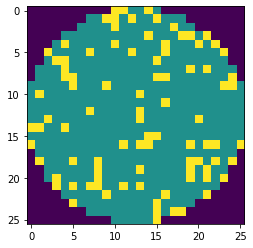

Faulty case : ['none'] 


In [343]:
# plot 1st data 보여주고
plt.imshow(x[0])
plt.show()

# check faulty case: failure type
print('Faulty case : {} '.format(y[0]))

In [344]:
#add channel
x = x.reshape((-1, 26, 26, 1))

faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [345]:
#26*26 size map의 failure type별 데이터 개수
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [187]:
# One-hot-Encoding faulty categorical variable as channel
new_x_Org = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x_Org[w, i, j, int(x[w, i, j])] = 1

none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
# delete choiced index data.
new_x_Org = np.delete(new_x_Org, none_idx, axis=0)
new_y_Org = np.delete(y, none_idx, axis=0)

print('삭제 후 "none" class의 shape, new_x shape : {}, new_y shape : {}'.format(new_x_Org.shape, new_y_Org.shape))
# string label data → numerical data
for i, l in enumerate(faulty_case):
    new_y_Org[new_y_Org==l] = i
    
# one-hot-encoding
new_y_Org = to_categorical(new_y_Org)

# split data "train", "test"
x_train_Org, x_test_Org, y_train_Org, y_test_Org = train_test_split(new_x_Org, new_y_Org,
                                                    test_size=0.3,
                                                    random_state=2019)

# 모델 상호 검증: Using sklearn KFold Cross validation

# keras model: sklearn classifier.
model_Org = KerasClassifier(build_fn=create_model, epochs=10, batch_size=50, verbose=2) 

history_org = model_Org.fit(x_train_Org, y_train_Org,         
         epochs=10,
         batch_size=100,
         validation_data=(x_test_Org, y_test_Org)
         )

삭제 후 "none" class의 shape, new_x shape : (3366, 26, 26, 3), new_y shape : (3366, 1)
Epoch 1/10
24/24 - 10s - loss: 1.3609 - accuracy: 0.7394 - val_loss: 0.8234 - val_accuracy: 0.7574
Epoch 2/10
24/24 - 9s - loss: 0.5885 - accuracy: 0.8209 - val_loss: 0.5559 - val_accuracy: 0.8347
Epoch 3/10
24/24 - 9s - loss: 0.3318 - accuracy: 0.9020 - val_loss: 0.4082 - val_accuracy: 0.8990
Epoch 4/10
24/24 - 10s - loss: 0.2758 - accuracy: 0.9185 - val_loss: 0.4075 - val_accuracy: 0.8990
Epoch 5/10
24/24 - 9s - loss: 0.1898 - accuracy: 0.9376 - val_loss: 0.3759 - val_accuracy: 0.8980
Epoch 6/10
24/24 - 9s - loss: 0.1181 - accuracy: 0.9618 - val_loss: 0.3695 - val_accuracy: 0.9069
Epoch 7/10
24/24 - 9s - loss: 0.0920 - accuracy: 0.9758 - val_loss: 0.3546 - val_accuracy: 0.9129
Epoch 8/10
24/24 - 9s - loss: 0.0356 - accuracy: 0.9915 - val_loss: 0.4166 - val_accuracy: 0.9119
Epoch 9/10
24/24 - 9s - loss: 0.0195 - accuracy: 0.9958 - val_loss: 0.4648 - val_accuracy: 0.9040
Epoch 10/10
24/24 - 9s - loss: 0.

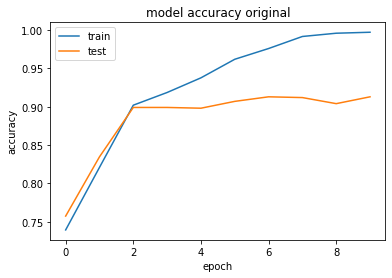

In [188]:
# accuracy chart
# accuracy plot 
plt.plot(history_org.history['accuracy'])
plt.plot(history_org.history['val_accuracy'])
plt.title('model accuracy original')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

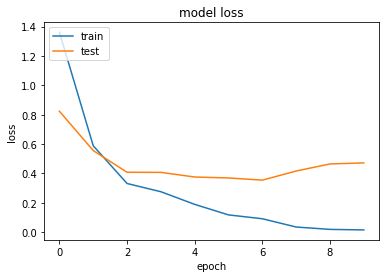

In [190]:
# loss plot
plt.plot(history_org.history['loss'])
plt.plot(history_org.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [193]:
np.max(history_org.history['val_accuracy'])

0.9128713011741638

In [192]:
np.max(history_org.history['accuracy'])

0.9970288872718811

In [346]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [347]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [99]:
# parameter
epoch=15
batch_size=1024

# Encoder 부분
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder 부분, Decoder는 레이어에 바로 이전 값을 넣지 않고, Layer 자체로 변수로 저장합니다.
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# 레이어로 저장한 Decoder Layer에 Latent vector 부터 순서대로 Decoding하며 연결합니다.
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

# AutoEncoder 모델 정의
ae = models.Model(input_tensor, output_tensor(decode))
# AutoEncoder 모델 생성(컴파일), 최적화기는 Adam, mse를 사용합니다.
ae.compile(optimizer = 'Adam', loss = 'mse',)

ae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

In [100]:
# start train
ae_history = ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 10s - loss: 0.1592
Epoch 2/15
15/15 - 9s - loss: 0.0959
Epoch 3/15
15/15 - 9s - loss: 0.0843
Epoch 4/15
15/15 - 9s - loss: 0.0728
Epoch 5/15
15/15 - 9s - loss: 0.0640
Epoch 6/15
15/15 - 9s - loss: 0.0569
Epoch 7/15
15/15 - 9s - loss: 0.0509
Epoch 8/15
15/15 - 9s - loss: 0.0459
Epoch 9/15
15/15 - 9s - loss: 0.0412
Epoch 10/15
15/15 - 9s - loss: 0.0367
Epoch 11/15
15/15 - 9s - loss: 0.0327
Epoch 12/15
15/15 - 9s - loss: 0.0293
Epoch 13/15
15/15 - 9s - loss: 0.0264
Epoch 14/15
15/15 - 9s - loss: 0.0239
Epoch 15/15
15/15 - 9s - loss: 0.0218


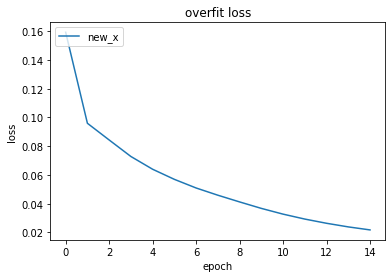

In [101]:
# loss plot
plt.plot(ae_history.history['loss'])
plt.title('overfit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['new_x'], loc='upper left')
plt.show()

In [102]:
# Encoder 모델 정의 *compile을 통해 모델을 생성하지 않는 이유는
# 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
encoder = models.Model(input_tensor, latent_vector)

# Decoder 모델
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

# Decoder 모델 정의, *compile을 통해 모델을 생성하지 않는 이유는
# 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
decoder = models.Model(decoder_input, output_tensor(decode))

# Encode - original 불량 wafer
encoded_x = encoder.predict(new_x)

# 잠재적 불량 wafer vector에 노이즈를 추가
# 원본 불량 데이터를 축소시켜 만든 Latent 데이터에 약간의 노이즈를 더해 새로운 데이터를 생성 합니다.
# numpy.random.normal 함수는 loc=평균, scale=표준편차를 가진 정규 분포 노이즈를 생성 합니다.
noised_encoded_x = encoded_x + np.random.normal(loc=0, 
                                                scale=0.1, 
                                                size = (len(encoded_x), 13, 13, 64))

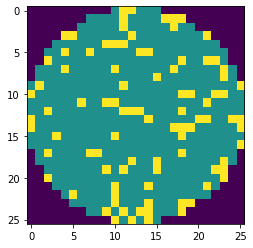

In [103]:
# 원본 불량 데이터 확인
plt.imshow(np.argmax(new_x[3], axis=2))

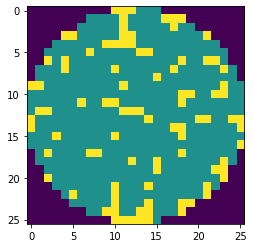

In [104]:
# 노이즈를 섞어 만든 불량 데이터 확인
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

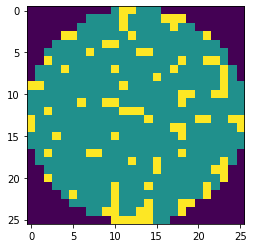

In [105]:
# AutoEncoder가 복원시킨 원본 불량 데이터 확인
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

# ------------------ Data augmentation ------------------------

In [348]:
# Data 증강
def gen_data(wafer, label):
    # 입력 wafer Encode
    encoded_x = encoder.predict(wafer)
    
    # 생성한 wafer 데이터를 모을 틀을 만듭니다.
    gen_x = np.zeros((1, 26, 26, 3))
    
    # augmentation
    # 각 클래스가 가지고 있는 데이터의 수가 2천개가 되도록 반복하여 데이터를 생성합니다.
    # ex) 가지고 있는 데이터의 수가 2개라면, 2000//2 = 1000, 한번에 2개씩 1000번 2천개의 데이터를 생성합니다.
    for i in range((13400//len(wafer)) + 1):
        # Encoding한 데이터에 노이즈를 가해 새로운 데이터를 생성합니다.
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
     # 생성한 데이터의 개수에 맞게 레이블도 생성해줍니다.
    gen_y = np.full((len(gen_x), 1), label)
    
    # 데이터를 반환할 때 0번 인덱스에 있는 데이터는 가짜 데이터이므로 제외하고 반환합니다.
    return gen_x[1:], gen_y[1:]

In [349]:
# class별 데이터의 Augmentation 
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
     # 현재 불량 케이스에 대한 wafer 이미지와, 라벨 값을 전달해 데이터를 생성합니다.
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [350]:
print('증강 후, new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

증강 후, new_x shape : (122218, 26, 26, 3), new_y shape : (122218, 1)


In [351]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 13500
Donut : 13402
Edge-Loc : 13912
Edge-Ring : 13454
Loc : 13959
Near-full : 13424
Random : 13542
Scratch : 13536
none : 13489


In [352]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

print('삭제 후 "none" class의 shape, new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

삭제 후 "none" class의 shape, new_x shape : (111218, 26, 26, 3), new_y shape : (111218, 1)


In [353]:
none_idx

array([10814, 14168,  2349, ...,  4363, 13019, 12513], dtype=int64)

In [354]:
# string label data → numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

# split data "train", "test"
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.3,
                                                    random_state=2019)

print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (77852, 26, 26, 3), y : (77852, 9)
Test x: (33366, 26, 26, 3), y : (33366, 9)


In [112]:
# The data is ready. As wafer data is image. simply use cnn for classification.

In [355]:
x_train.shape


(77852, 26, 26, 3)

In [356]:
y_train.shape

(77852, 9)

In [114]:
# 모델 상호 검증: Using sklearn KFold Cross validation

# keras model: sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# accuracy printing (3-fold model')
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
49/49 - 103s - loss: 0.8461 - accuracy: 0.7222
Epoch 2/10
49/49 - 103s - loss: 0.0473 - accuracy: 0.9877
Epoch 3/10
49/49 - 103s - loss: 0.0138 - accuracy: 0.9966
Epoch 4/10
49/49 - 103s - loss: 0.0106 - accuracy: 0.9972
Epoch 5/10
49/49 - 103s - loss: 0.0082 - accuracy: 0.9981
Epoch 6/10
49/49 - 103s - loss: 0.0061 - accuracy: 0.9984
Epoch 7/10
49/49 - 106s - loss: 0.0064 - accuracy: 0.9983
Epoch 8/10
49/49 - 104s - loss: 0.0049 - accuracy: 0.9986
Epoch 9/10
49/49 - 106s - loss: 0.0050 - accuracy: 0.9986
Epoch 10/10
49/49 - 107s - loss: 0.0053 - accuracy: 0.9984
25/25 - 14s - loss: 0.0077 - accuracy: 0.9979
Epoch 1/10
49/49 - 108s - loss: 0.7867 - accuracy: 0.7554
Epoch 2/10
49/49 - 106s - loss: 0.0484 - accuracy: 0.9884
Epoch 3/10
49/49 - 106s - loss: 0.0144 - accuracy: 0.9966
Epoch 4/10
49/49 - 109s - loss: 0.0084 - accuracy: 0.9981
Epoch 5/10
49/49 - 108s - loss: 0.0080 - accuracy: 0.9981
Epoch 6/10
49/49 - 107s - loss: 0.0078 - accuracy: 0.9983
Epoch 7/10
49/49 - 106s -

In [167]:
# accuracy chart
# accuracy plot 
plt.plot(results.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'history'

In [141]:
tt = create_model()
tt.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               44302848  
_________________________________________________________________
dense_19 (Dense)             (None, 128)               656

In [115]:
batch_size

1024

In [374]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(77852, 26, 26, 3)
(77852, 9)
(33366, 26, 26, 3)
(33366, 9)


In [117]:
print(x_train.shape)
print(y_train.shape)

(74516, 26, 26, 3)
(74516, 9)


In [118]:
y_train.dtype

dtype('float32')

In [119]:
# Our model seems quite a good model.
history = model.fit(x_train, y_train,         
         epochs=epoch,
         batch_size=batch_size,
         validation_data=(x_test, y_test)
         )

Epoch 1/15
73/73 - 176s - loss: 0.5853 - accuracy: 0.8211 - val_loss: 0.0566 - val_accuracy: 0.9820
Epoch 2/15
73/73 - 178s - loss: 0.0211 - accuracy: 0.9952 - val_loss: 0.0174 - val_accuracy: 0.9950
Epoch 3/15
73/73 - 177s - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0174 - val_accuracy: 0.9967
Epoch 4/15
73/73 - 175s - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0137 - val_accuracy: 0.9973
Epoch 5/15
73/73 - 176s - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0112 - val_accuracy: 0.9974
Epoch 6/15
73/73 - 179s - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0096 - val_accuracy: 0.9971
Epoch 7/15
73/73 - 174s - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0092 - val_accuracy: 0.9970
Epoch 8/15
73/73 - 174s - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0097 - val_accuracy: 0.9975
Epoch 9/15
73/73 - 174s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0128 - val_accuracy: 0.9974
Epoch 10/15
73/73 - 174s - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0097 - val_accuracy: 0.9968

0.9864440759023031

In [359]:

print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))
print('Simple CNN Cross validation score : {:.4f}'.format(np.max(results)))
print('Simple CNN Cross validation score : {:.4f}'.format(np.average(results)))
print('CNN Cross validation score : {:.4f}'.format(np.mean(history.history['accuracy'])))
print('CNN Cross validation score : {:.4f}'.format(np.max(history.history['accuracy'])))

Simple CNN Cross validation score : 0.9975
Simple CNN Cross validation score : 0.9979
Simple CNN Cross validation score : 0.9975
CNN Cross validation score : 0.9864
CNN Cross validation score : 0.9988


Epoch 1/10
49/49 - 107s - loss: 0.8754 - accuracy: 0.7221
Epoch 2/10
49/49 - 105s - loss: 0.1018 - accuracy: 0.9712
Epoch 3/10
49/49 - 105s - loss: 0.0180 - accuracy: 0.9963
Epoch 4/10
49/49 - 105s - loss: 0.0133 - accuracy: 0.9966
Epoch 5/10
49/49 - 104s - loss: 0.0090 - accuracy: 0.9975
Epoch 6/10
49/49 - 104s - loss: 0.0073 - accuracy: 0.9983
Epoch 7/10
49/49 - 105s - loss: 0.0068 - accuracy: 0.9981
Epoch 8/10
49/49 - 105s - loss: 0.0066 - accuracy: 0.9983
Epoch 9/10
49/49 - 105s - loss: 0.0063 - accuracy: 0.9985
Epoch 10/10
49/49 - 106s - loss: 0.0053 - accuracy: 0.9986
25/25 - 14s - loss: 0.0128 - accuracy: 0.9937
Epoch 1/10
49/49 - 103s - loss: 0.8618 - accuracy: 0.7171
Epoch 2/10
49/49 - 102s - loss: 0.0454 - accuracy: 0.9890
Epoch 3/10
49/49 - 102s - loss: 0.0129 - accuracy: 0.9973
Epoch 4/10
49/49 - 102s - loss: 0.0083 - accuracy: 0.9979
Epoch 5/10
49/49 - 102s - loss: 0.0090 - accuracy: 0.9978
Epoch 6/10
49/49 - 102s - loss: 0.0080 - accuracy: 0.9980
Epoch 7/10
49/49 - 101s -

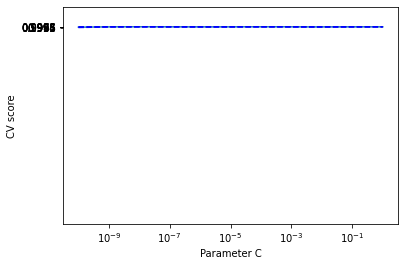

In [170]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

svc = svm.SVC(kernel="linear")
C_s = np.logspace(-10, 0, 10)
scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(model, x_train, y_train, cv=kfold)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

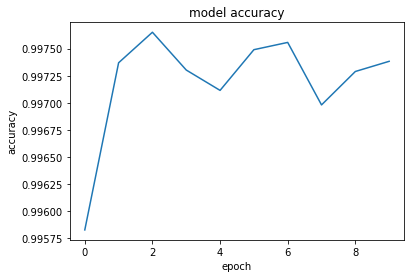

In [178]:

# API(cross_val_score) accuracy chart
plt.plot(scores)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [201]:
np.max(scores)

0.9976515173912048

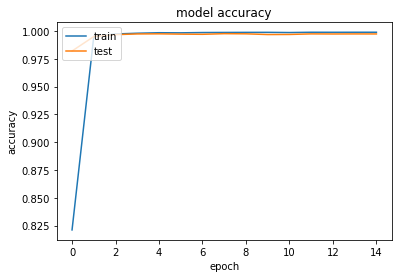

In [120]:
# accuracy chart
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

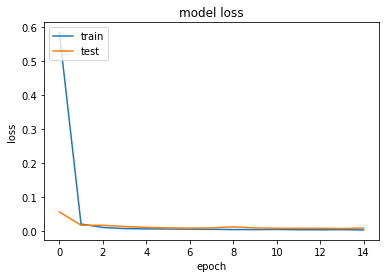

In [121]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()